In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import torch
from torch import manual_seed, nn, no_grad, optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch import (cuda, float32, manual_seed, nn, no_grad, optim,
                   set_default_device, tensor)
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from statistics import mean, stdev
from torchsummary import summary

import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

# set random seed for reproducibility
#torch.manual_seed(234);

using device: cpu


In [81]:
class HydraullicDataset(Dataset):
    def __init__(self, train_input, train_output, device='cpu'):
        self.input = torch.tensor(train_input, dtype=torch.float32).unsqueeze(1).to(device)#**2
        self.output = torch.tensor(train_output, dtype=torch.float32).to(device)

    def __len__(self):
        # Return the total number of samples in the dataset
        return self.input.shape[0]

    def __getitem__(self, idx):
        # Retrieve the input and corresponding output by index
        input_ = self.input[idx]
        output_ = self.output[idx]
        return input_, output_

def square_plot(data):
    '''Creates a square plot of the input array as seen in the assignment description, assert statements check
    whether the data is length 40.'''
    assert len(data) == 40, 'Top level array length is not 40'
    assert len(data[0]) == 40, 'Bottom level array length is not 40'
    plt.imshow(data, cmap='gray')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    return plt
    
def load_data(train_input, train_output, test_input):
    '''Loads the training and the test data from the directory.
    Returns in the following order:
     1. Training input
     2. Training output
     3. Testing input'''
    input_train_data  = np.load(train_input)
    output_train_data =   np.load(train_output)
    input_test_data   =    np.load(test_input)
    return input_train_data, output_train_data, input_test_data

def disp_datarow(DataRow):
    '''Displays the square plot with the corresponding S value.'''
    plot = square_plot(DataRow[0][0])
    plot.title(f'Output S = {DataRow[1]:.3f}[m^4]')
    
def plot_losses(loss):
    plt.semilogy(loss['train'], label="train", marker=".", lw=2)
    plt.semilogy(loss['val'], label="val", marker=".", lw=2)
    plt.legend()
    plt.show()
    
def rmspe ( ypred , ytrue ):
    return (((ytrue - ypred ) / ytrue )**2).mean().sqrt()


In [88]:
in_train_data_OG, out_train_data_OG, in_test_data_OG = load_data(
    'pub_input.npy', 'pub_out.npy', 'pri_in.npy'
)

In [95]:
in_train_data, out_train_data, in_test_data = load_data(
    'pub_input.npy', 'pub_out.npy', 'pri_in.npy'
)

def disambiguate(x):
    """ 
    rotates / reflects s.t. the lower top left octant has the most 1s.
    """
    sums = []
    for i in range(4):

        array = np.rot90(x,k = i)

        top_left_quadrant = array[:half_size, :half_size]
        bot_triangle_sum = sum([top_left_quadrant[i][j] for i in range(20) for j in range(20) if i<=j])
        top_triangle_sum = sum([top_left_quadrant[i][j] for i in range(20) for j in range(20) if i>=j])
        sums.append(bot_triangle_sum)
        sums.append(top_triangle_sum)

    max_sums_arg = np.argmax(sums)

    if max_sums_arg == 0:
        pass 
    if max_sums_arg == 1:
        x = np.transpose(x)
    if max_sums_arg == 2:
        x = np.rot90(x , 1)
    if max_sums_arg == 3:
        x = np.rot90(x , 1)
        x = np.transpose(x)
    if max_sums_arg == 4:
        x = np.rot90(x , 2)
    if max_sums_arg == 5:
        x = np.rot90(x , 2)
        x = np.transpose(x)
    if max_sums_arg == 6:
        x = np.rot90(x , 3)
    if max_sums_arg == 7:
        x = np.rot90(x , 3)
        x = np.transpose(x)

    return x


train_data_list = []
test_data_list = []
for x in in_train_data:
    new_x = disambiguate(x)
    train_data_list.append(new_x)
for x in in_test_data:
    new_x = disambiguate(x)
    test_data_list.append(new_x)  
in_train_data = np.array(train_data_list)
in_test_data = np.array(test_data_list)

In [98]:

train_dataset = HydraullicDataset(in_train_data,out_train_data**0.5)

### COPIED FROM LAB 8 SOLUTIONS
# split the data into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [99]:
class ApplySymmetry(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x_lr = np.fliplr(x)
        x_ud = np.flipud(x)
        x_lr_ud = np.fliplr(np.flipud(x))
        x_90 = np.rot90(x,1)
        x_180 = np.rot90(x_90,1)
        x_270 = np.rot90(x_180,1)
        x_diag1 = np.rot90(np.fliplr(x),1)
        x_diag2 = np.rot90(np.fliplr(x),2)
        
        return torch.cat([x, x_lr, x_ud, x_lr_ud, x_diag1, x_diag2], dim=1).view(-1, x.size()[1])


class GroupAverage(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(-1, 2).mean(dim=1).unsqueeze(dim=-1)

class SquareRoot(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sqrt(x)

class HydraullicModel(nn.Module):
    
    width = 256
    
    def __init__(self, width=width):
        super(HydraullicModel, self).__init__()
        ksize = 5
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=ksize, stride=1, padding=ksize//2, bias=False)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=ksize, stride=1, padding=ksize//2, bias=False)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=ksize, stride=1, padding=ksize//2, bias=False)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=ksize, stride=1, padding=ksize//2, bias=False)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=ksize, stride=1, padding=ksize//2, bias=False)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=ksize, stride=1, padding=ksize//2, bias=False)
        
        # Pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Linear Layer
        self.fc1 = nn.Linear(400,1,bias=False)
        

      
    def forward(self, x, width=width):
#        ApplySymmetry()
        x = F.relu(self.conv1(x))  
        x = F.relu(self.conv2(x)) 
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))   
        x = F.relu(self.conv6(x))
        x = self.maxpool(x)
       
        x = self.flatten(x)
        x = self.fc1(x)
#        GroupAverage()

        # SquareRoot()
        return x

In [100]:
def train_model(train_loader,
                val_loader, 
                model,
                nepochs=1,
                lr=1e-4,
                loss_fn=rmspe,
                batch_size = 32,
                plot_result=True):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_dict = {"train": [], "val": []}

    # Set up the main tqdm loop for epochs
    epochs_tqdm = tqdm(range(nepochs), desc='Training Model')
    

    for epoch in epochs_tqdm:
        model.train()
        epoch_loss_sum = 0

        # Train loop without tqdm for individual batches
        for x_batch, y_batch in train_loader:
            y_batch = y_batch.unsqueeze(1)
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            epoch_loss_sum += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = epoch_loss_sum / len(train_loader)
        loss_dict["train"].append(avg_train_loss)

        # Validation loop without tqdm for individual batches
        # model.eval()
        val_loss_sum = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                y_val = y_val.unsqueeze(1)
                y_pred = model(x_val)
                # print(y_val)
                # print(y_pred)
                loss = loss_fn(y_pred, y_val)
                val_loss_sum += loss.item()

        avg_val_loss = val_loss_sum / len(val_loader)
        loss_dict["val"].append(avg_val_loss)
        
        # Update tqdm bar only once per epoch with the average losses
        epochs_tqdm.set_description(f'Epoch {epoch+1}/{nepochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}')

        if True:
            mean_val_loss = mean(loss_dict['val'][-5:])
            mean_train_loss = mean(loss_dict['train'][-5:])
        
            if epoch > 30 and mean_val_loss > mean(loss_dict['val'][-30:-25]):
                break
    
            # if epoch > 25 and mean_val_loss * 1.01 > mean_train_loss:
            #     break
        
    if plot_result:
        plot_losses(loss_dict)
            
            
    return model, loss_dict


In [101]:
# Define model arguments
max_epochs = 500
lr = 1e-5
loss_fn = rmspe
set_exit_condition = False

In [102]:
model = HydraullicModel().to(device)

model, loss_dict = train_model(
    train_loader, 
    val_loader,
    model,
    nepochs=max_epochs,
    lr=lr,
    loss_fn=loss_fn,
    batch_size=2**4,
    plot_result=True)


Epoch 17/500 - Train Loss: 0.4331 - Val Loss: 0.4331:   3%|▎         | 17/500 [00:46<21:53,  2.72s/it]

In [9]:
y_pred = model(torch.tensor(in_train_data, dtype=torch.float32).unsqueeze(1).to(device))
print(y_pred[:10])
print(out_train_data[:10])
#plot_losses(loss_dict)
summary(model, input_size=(1, 40, 40))

tensor([[0.0221],
        [0.0235],
        [0.0247],
        [0.0233],
        [0.0235],
        [0.0232],
        [0.0214],
        [0.0229],
        [0.0205],
        [0.0238]], grad_fn=<SliceBackward0>)
[164338.46593651  46746.81334228  80348.49552069  14946.36130238
  44199.73623184  31977.14810429  10868.55785031 110398.06064496
   4069.27194573  17480.86937576]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 40, 40]             400
            Conv2d-2           [-1, 32, 40, 40]          12,800
         MaxPool2d-3           [-1, 32, 20, 20]               0
            Conv2d-4           [-1, 32, 20, 20]          25,600
            Conv2d-5           [-1, 32, 20, 20]          25,600
         MaxPool2d-6           [-1, 32, 10, 10]               0
            Conv2d-7           [-1, 16, 10, 10]          12,800
            Conv2d-8           [-1, 16, 10, 10]     

In [10]:
### GENERATE OUTPUT CSV

model = torch.load('model_2024-06-16 17_48_47')

y_pred = model(torch.tensor(in_test_data, dtype=torch.float32).unsqueeze(1).to(device))
y_pred_kag = y_pred.detach().numpy()
print(y_pred_kag)
pd.DataFrame(y_pred_kag).to_csv("kaggle_submission.csv", header=["Solution"], index_label="Id")


[[232.96567  ]
 [300.31537  ]
 [ 79.87291  ]
 [290.57675  ]
 [301.463    ]
 [  3.589933 ]
 [107.61446  ]
 [427.89316  ]
 [118.00066  ]
 [230.52362  ]
 [466.4202   ]
 [348.1073   ]
 [308.36523  ]
 [124.03862  ]
 [100.723114 ]
 [519.90533  ]
 [112.0101   ]
 [ 11.852927 ]
 [337.92978  ]
 [385.60635  ]
 [199.84584  ]
 [350.241    ]
 [487.52155  ]
 [ 63.40119  ]
 [ 90.42049  ]
 [514.36096  ]
 [475.48065  ]
 [ 62.8179   ]
 [377.97714  ]
 [367.9428   ]
 [246.53369  ]
 [202.8699   ]
 [ 85.01096  ]
 [ 86.84242  ]
 [410.162    ]
 [ 36.279934 ]
 [524.61035  ]
 [ 42.042046 ]
 [103.786285 ]
 [117.91589  ]
 [203.49713  ]
 [ 91.71545  ]
 [  5.297459 ]
 [ 71.79582  ]
 [374.43103  ]
 [ 24.542858 ]
 [115.894585 ]
 [ 12.914018 ]
 [538.7208   ]
 [158.25128  ]
 [305.76346  ]
 [468.34253  ]
 [199.63416  ]
 [328.30396  ]
 [ 93.710724 ]
 [115.0199   ]
 [ 71.704926 ]
 [278.0191   ]
 [292.959    ]
 [471.29947  ]
 [283.9135   ]
 [337.621    ]
 [206.24857  ]
 [398.0841   ]
 [365.21817  ]
 [240.07944  ]
 [ 27.7334

In [36]:
def train_model_kaggle(train_loader,
                val_loader, 
                model,
                nepochs=1,
                lr=1e-4,
                loss_fn=rmspe,
                batch_size = 32,
                plot_result=True):
    t = 2
    results = []
    while t > 0:
        
        model = HydraullicModel().to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        loss_dict = {"train": [], "val": []}

        # Set up the main tqdm loop for epochs
        epochs_tqdm = tqdm(range(nepochs), desc='Training Model')
        

        for epoch in epochs_tqdm:
            model.train()
            epoch_loss_sum = 0

            # Train loop without tqdm for individual batches
            for x_batch, y_batch in train_loader:
                y_batch = y_batch.unsqueeze(1)
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                epoch_loss_sum += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            avg_train_loss = epoch_loss_sum / len(train_loader)
            loss_dict["train"].append(avg_train_loss)

            # Validation loop without tqdm for individual batches
            # model.eval()
            val_loss_sum = 0
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    y_val = y_val.unsqueeze(1)
                    y_pred = model(x_val)
                    # print(y_val)
                    # print(y_pred)
                    loss = loss_fn(y_pred, y_val)
                    val_loss_sum += loss.item()

            avg_val_loss = val_loss_sum / len(val_loader)
            loss_dict["val"].append(avg_val_loss)
            
            # Update tqdm bar only once per epoch with the average losses
            epochs_tqdm.set_description(f'Epoch {epoch+1}/{nepochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}')

            if True:
                mean_val_loss = mean(loss_dict['val'][-15:])
                mean_train_loss = mean(loss_dict['train'][-15:])
            
                if epoch > 30 and mean_val_loss > mean_train_loss*1.05:
                    break
            
        if plot_result:
            plot_losses(loss_dict)
              
        results.append((model, loss_dict))

        t -= 1
    
    return results


Epoch 15/15 - Train Loss: 0.9991 - Val Loss: 0.9989: 100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


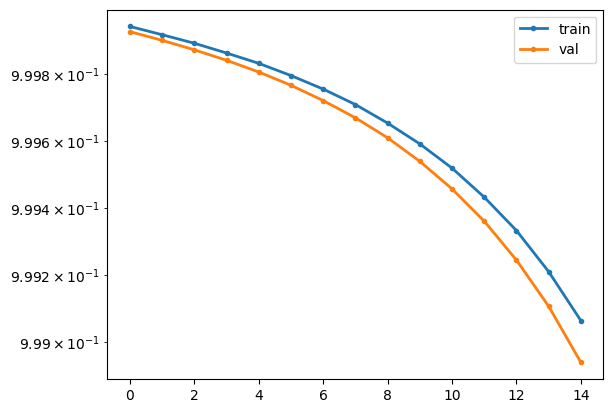

Epoch 15/15 - Train Loss: 0.9989 - Val Loss: 0.9988: 100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


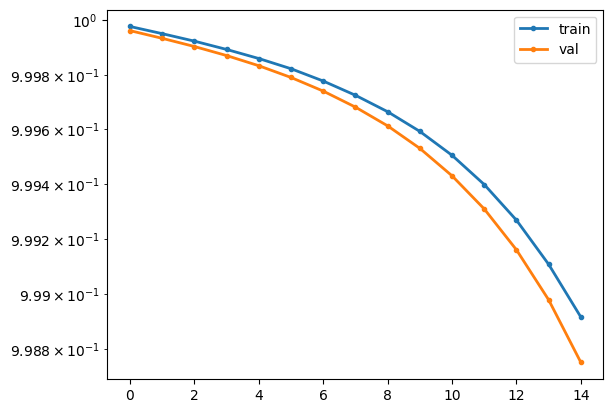

In [37]:
max_epochs = 15
lr = 1e-6
loss_fn = rmspe
set_exit_condition = False

model = HydraullicModel().to(device)

results = train_model_kaggle(train_loader, 
    val_loader,
    model,
    nepochs=max_epochs,
    lr=lr,
    loss_fn=loss_fn,
    batch_size=2**6,
    plot_result=True)

In [64]:
# Code for running in kaggle
mean_loss_list = []
for index in range(len(results)):
    loss_dictionary = results[index][1]
    mean_loss_list.append(mean([mean(loss_dictionary['train'][-5:]) , mean(loss_dictionary['val'][-5:])]))
    best_model = results[np.argmax(mean_loss_list)][0]    

torch.save(best_model , f"model_{time.time()}")
